In [29]:
import pandas as pd
import pickle as pkl
import numpy as np
vgg_oof = pd.read_csv('../KIc/Model/vgg/vgg16_Kfold_seed42_oof_df.csv')
vit_oof = pd.read_csv('../KIc/Model/vit/vit_large_patch32_224_Kfold_seed42_oof_df.csv')
f = open("../Mototake_Analysis/VGG+GP/Y_pred_rational_seed42.pkl","rb")
plot_Y_rational = pkl.load(f)
f.close()
vgg_oof['VGG+GP_preds'] = plot_Y_rational[1][3]
vgg_oof['truekic'] = plot_Y_rational[0][3]

# vgg_oof = vgg_oof.sort_values(by='Id').reset_index(drop=True)
# vit_oof = vit_oof.sort_values(by='Id').reset_index(drop=True)

np.mean(vit_oof['KIc'] - vgg_oof['KIc'])
# np.mean(vgg_oof['KIc'] - vit_oof['KIc'])

0.0

In [1]:
# !pip install imgsim
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import cv2
import imgsim
import cv2
import os
vtr = imgsim.Vectorizer()

def cos_sim(v1, v2):
    v1 = (v1 - np.mean(v1)) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    v2 = (v2 - np.mean(v2)) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.dot(v1, v2)

# ====================================================
# DATA
# ====================================================
vgg_oof = pd.read_csv('../KIc/Model/vgg/vgg16_Kfold_seed42_oof_df.csv')
vit_oof = pd.read_csv('../KIc/Model/vit/vit_large_patch32_224_Kfold_seed42_oof_df.csv')
f = open("../Mototake_Analysis/VGG+GP/Y_pred_rational_seed42.pkl","rb")
plot_Y_rational = pkl.load(f)
f.close()
vgg_oof['VGG+GP_preds'] = plot_Y_rational[1][3]

vgg_oof = vgg_oof.sort_values(by='Id').reset_index(drop=True)
vit_oof = vit_oof.sort_values(by='Id').reset_index(drop=True)

vgg_oof['vgg_diff'] = abs(vgg_oof['preds'] - vgg_oof['KIc'])
vit_oof['vit_diff'] = abs(vit_oof['preds'] - vit_oof['KIc'])
vgg_gp = abs(vgg_oof['VGG+GP_preds'] - vgg_oof['KIc'])
vit_oof['vit_diff_from_vgg'] = vgg_oof['vgg_diff'] - vit_oof['vit_diff']
vit_oof['vit_absdiff_from_vgg'] = abs(vgg_oof['vgg_diff'] - vit_oof['vit_diff'])

n = 30
better_id_list = vit_oof.nlargest(n, 'vit_diff_from_vgg')['Id']
worse_id_list = vit_oof.nsmallest(n, 'vit_absdiff_from_vgg')['Id']

# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in better case
# --------------------------------------------------------------------------------
better_dist_ar = np.zeros(n)
better_cos_ar = np.zeros(n)

for idx, better_id in enumerate(better_id_list):
    print('id : ', idx)
    image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(better_id) + '.jpg'
    img0 = cv2.imread(image_path)

    img1 = img0[:int(img0.shape[0]/2), :]
    # plt.imshow(img1)
    # plt.show()
    img2 = img0[int(img0.shape[0]/2):, :][::-1] if img0.shape[0] % 2 == 0 else img0[int(img0.shape[0]/2):img0.shape[0]-1, :][::-1]
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)
    better_dist_ar[idx] = dist

    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = img1.flatten()
    img2 = img2.flatten()
    better_cos_ar[idx] = cos_sim(img1,img2)
    print("distance =", dist)
    print("distance =", cos_sim(img1,img2))


# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in worse case
# --------------------------------------------------------------------------------
worse_dist_ar = np.zeros(n)
worse_cos_ar = np.zeros(n)

for idx, worse_id in enumerate(worse_id_list):
    print('id : ', idx)
    image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/'\
                 + str(worse_id) + '.jpg'
    img0 = cv2.imread(image_path)
        
    img1 = img0[:int(img0.shape[0]/2), :]
    # plt.imshow(img1)
    # plt.show()
    img2 = img0[int(img0.shape[0]/2):, :][::-1] \
                if img0.shape[0] % 2 == 0 \
                else img0[int(img0.shape[0]/2):img0.shape[0]-1, :][::-1]
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)
    worse_dist_ar[idx] = dist
    
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = img1.flatten()
    img2 = img2.flatten()
    worse_cos_ar[idx] = cos_sim(img1,img2)
    print("distance =", dist)
    print("distance =", cos_sim(img1,img2))


# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in not symmetric case
# --------------------------------------------------------------------------------
# nonsym_better_dist_ar = np.zeros(n)
# nonsym_better_cos_ar = np.zeros(n)

# for idx, better_id in enumerate(better_id_list):
#     print('id : ', idx)
#     image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(better_id) + '.jpg'
#     img0 = cv2.imread(image_path)
    
#     img1 = img0[:int(img0.shape[0]/2), :]
#     # plt.imshow(img1)
#     # plt.show()
#     img2 = img0[int(img0.shape[0]/2):, :] if img0.shape[0] % 2 == 0 else img0[int(img0.shape[0]/2):img0.shape[0]-1, :]
#     # plt.imshow(img2)
#     # plt.show()

#     vec1 = vtr.vectorize(img1)
#     vec2 = vtr.vectorize(img2)

#     dist = imgsim.distance(vec1, vec2)
#     nonsym_better_dist_ar[idx] = dist
    
#     img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
#     img1 = img1.flatten()
#     img2 = img2.flatten()
#     nonsym_better_cos_ar[idx] = cos_sim(img1,img2)
#     print("distance =", dist)
#     print("distance =", cos_sim(img1,img2))


/home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
/home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


id :  0
distance = 11.997056
distance = 0.15070597500169183
id :  1
distance = 14.484389
distance = 0.19079678908781034
id :  2
distance = 6.6048455
distance = 0.16666742226594666
id :  3
distance = 10.318773
distance = 0.39239500706507763
id :  4
distance = 9.261565
distance = 0.16317458095572007
id :  5
distance = 13.054777
distance = 0.12436972622050647
id :  6
distance = 9.8977585
distance = 0.10791014504585204
id :  7
distance = 13.145858
distance = 0.07040092274831002
id :  8
distance = 11.870442
distance = 0.163671198645237
id :  9
distance = 9.777658
distance = 0.1763632635769587
id :  10
distance = 7.7855234
distance = 0.20536066536215136
id :  11
distance = 7.0957155
distance = 0.1564608502865541
id :  12
distance = 7.7473874
distance = 0.25535655197601964
id :  13
distance = 15.581334
distance = 0.23150855552165128
id :  14
distance = 11.8257265
distance = 0.1652349731738543
id :  15
distance = 7.187252
distance = 0.1951446325829272
id :  16
distance = 15.02737
distance = 0.

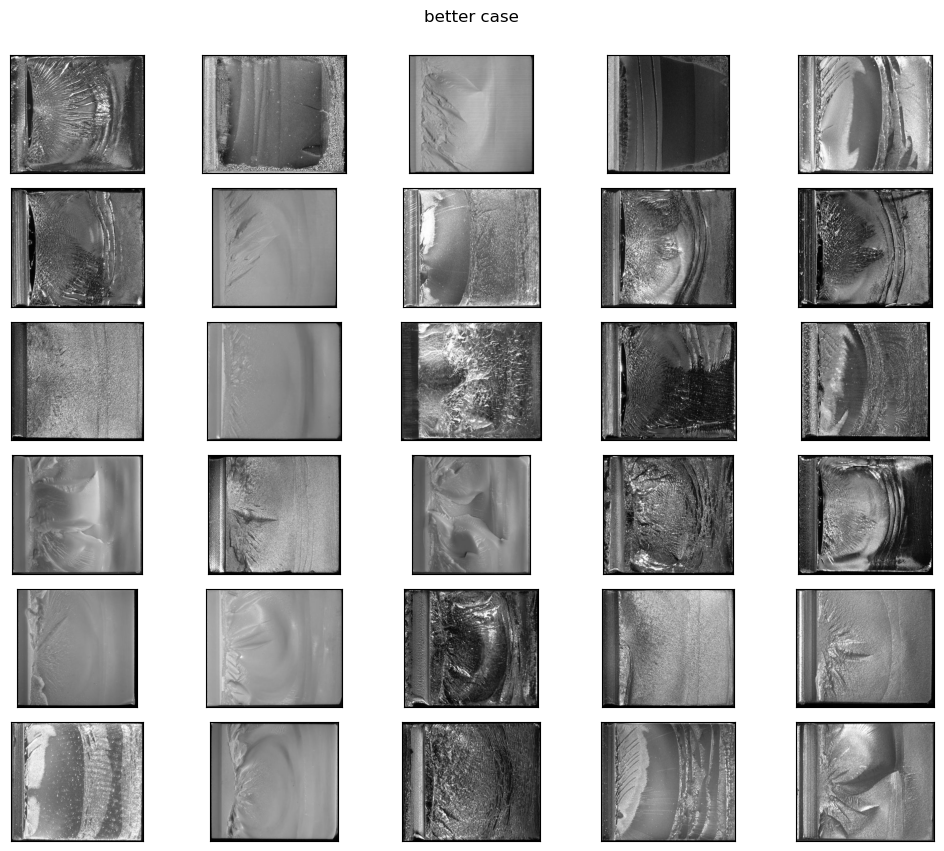

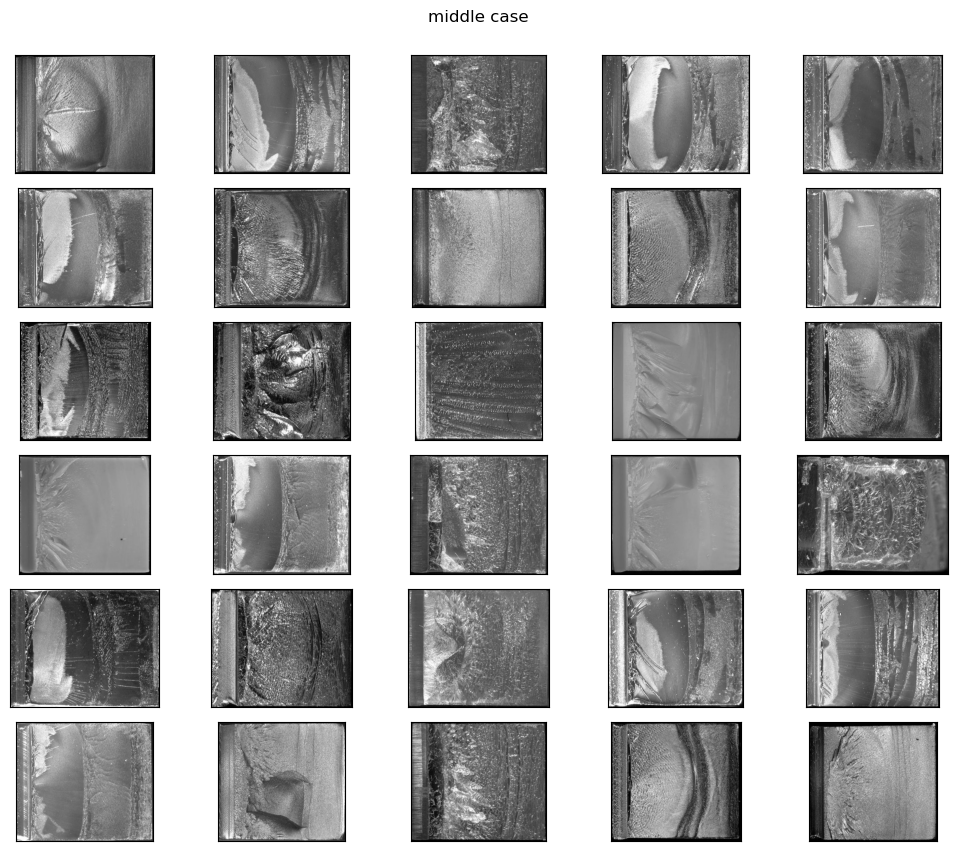

In [2]:
import matplotlib.pyplot as plt
import cv2
import glob
num_col=5

df_better = vit_oof.nlargest(30, 'vit_diff_from_vgg')
plt.figure(figsize=(10,int(len(df_better)*1.8/num_col)))
plt.suptitle('better case')
for i,path in enumerate(df_better['file_path']):
    plt.subplot(int(len(df_better)/num_col)+1,num_col,i+1)
    # plt.imshow(imread(glob.glob('/Users/yoshi/Desktop/破断面/sum/'+str(ID)+'*')[0]))
    plt.imshow(cv2.imread(path))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

df_worse = vit_oof.nsmallest(30, 'vit_absdiff_from_vgg')
plt.figure(figsize=(10,int(len(df_worse)*1.8/num_col)))
plt.suptitle('middle case')
for i,path in enumerate(df_worse['file_path']):
    plt.subplot(int(len(df_worse)/num_col)+1,num_col,i+1)
    # plt.imshow(imread(glob.glob('/Users/yoshi/Desktop/破断面/sum/'+str(ID)+'*')[0]))
    plt.imshow(cv2.imread(path))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


p01_value = 0.280339779269018


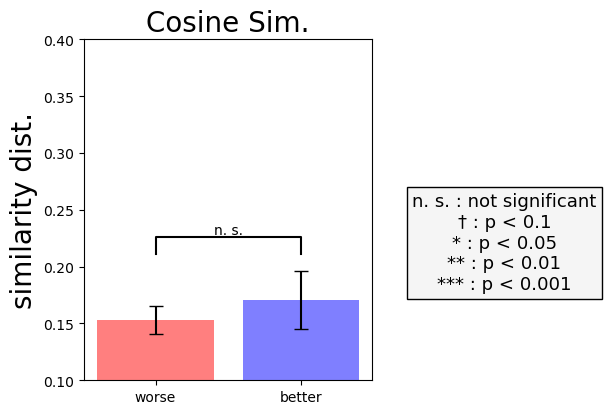

In [3]:
def barplot_annotate_brackets(num1, num2, data, center, 
                              height, yerr=None, dh=.05, 
                              barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.
  
    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
  
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # ↓↓↓↓↓↓↓↓↓↓↓
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        text = ''
        p = .05

        if data >= 0.1:
            text = 'n. s.'
        elif data < 0.1 and data >= 0.05:
            text = '†'
        elif data < 0.05 and data >= 0.01:
            text = '*'
        elif data < 0.01 and data >= 0.001:
            text = '**'
        elif data < 0.001:
            text = '***'
        
  
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
  
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
  
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
  
    y = max(ly, ry) + dh
  
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
  
    plt.plot(barx, bary, c='black')
  
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
  
    plt.text(*mid, text, **kwargs)
    
    #ボックス作成
    pos = plt.gca().get_position()
    s_text = "n. s. : not significant\n† : p < 0.1\n* : p < 0.05\n** : p < 0.01\n*** : p < 0.001"
    dic_box = {
        'facecolor' : 'whitesmoke',
        'edgecolor' : 'black',
        'linewidth' : 1
    }

    #文字とボックスの挿入
    plt.text(pos.x1+1.5, pos.y1-.7, s=s_text, 
            color='black', ha='center', fontsize='13', 
            bbox=dic_box)
   
""" main """
id = 0
n = 10
# Generate toy data
x0 = worse_cos_ar[id:n]
x1 = better_cos_ar[id:n]

# Welch’s t-test       
t01_value, p01_value = stats.ttest_ind(x0,x1,alternative='less')
print("p01_value =", p01_value)
""" plot """
heights = [np.mean(x0), np.mean(x1)]
std = [np.std(x0)/np.sqrt(n), np.std(x1)/np.sqrt(n)]
label = ["worse", "better"]
width = 0.8 # the width of the bars
bars = np.arange(len(heights))
colors = ["red", "blue"]

plt.figure(figsize=(7, 4))
plt.bar(bars, heights, width, tick_label=label, yerr=std, color=colors,
        align='center', alpha=0.5, ecolor='black', capsize=5)
plt.ylim(0.1,.40)
barplot_annotate_brackets(0, 1, p01_value, bars,
                          heights, yerr=std)
plt.tight_layout()
plt.ylabel("similarity dist.",fontsize=20)
plt.title("Cosine Sim.",fontsize=20)
plt.savefig("../Figure/cossim.eps")

plt.show()


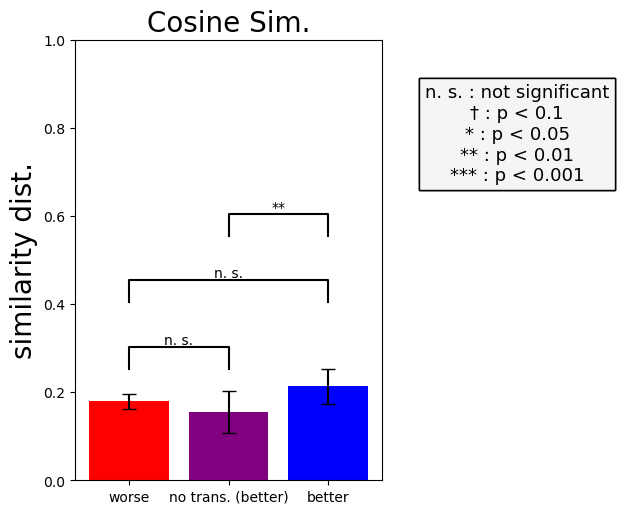

In [25]:
def barplot_annotate_brackets(num1, num2, data, center, 
                              height, yerr=None, dh=.05, 
                              barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.
  
    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
  
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # ↓↓↓↓↓↓↓↓↓↓↓
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        text = ''
        p = .05

        if data >= 0.1:
            text = 'n. s.'
        elif data < 0.1 and data >= 0.05:
            text = '†'
        elif data < 0.05 and data >= 0.01:
            text = '*'
        elif data < 0.01 and data >= 0.001:
            text = '**'
        elif data < 0.001:
            text = '***'
        
  
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
  
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
  
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
  
    y = max(ly, ry) + dh
  
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
  
    plt.plot(barx, bary, c='black')
  
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
  
    plt.text(*mid, text, **kwargs)
    
    #ボックス作成
    pos = plt.gca().get_position()
    s_text = "n. s. : not significant\n† : p < 0.1\n* : p < 0.05\n** : p < 0.01\n*** : p < 0.001"
    dic_box = {
        'facecolor' : 'whitesmoke',
        'edgecolor' : 'black',
        'linewidth' : 1
    }

    #文字とボックスの挿入
    plt.text(pos.x1+3, pos.y1-.2, s=s_text, 
            color='black', ha='center', fontsize='13', 
            bbox=dic_box)

""" main """
n=10
# Generate toy data
x0 = worse_cos_ar[:10]
x1 = nonsym_better_cos_ar[:10]
x2 = better_cos_ar[:10]
 
# Welch’s t-test       
t01_value, p01_value = stats.ttest_ind(x0,x1,alternative='less')
t02_value, p02_value = stats.ttest_ind(x0,x2,alternative='less')
t12_value, p12_value = stats.ttest_rel(x1,x2,alternative='less')
 
 
""" plot """
heights = [np.mean(x0), np.mean(x1), np.mean(x2)]
std = [np.std(x0)/np.sqrt(10), np.std(x1)/np.sqrt(n), np.std(x2)/np.sqrt(n)]
label = ["worse","no trans. (better)","better"]
width = 0.8 # the width of the bars
bars = np.arange(len(heights))
colors = ["red","purple","blue"]
  
plt.figure(figsize=(7, 5))
plt.bar(bars, heights, width, tick_label=label, yerr=std, color=colors,
        align='center', alpha=1, ecolor='black', capsize=5)
plt.ylim(0,1)
barplot_annotate_brackets(0, 1, p01_value, bars,
                          heights, yerr=std)
barplot_annotate_brackets(1, 2, p12_value, bars,
                          heights, yerr=std, dh=0.3)
barplot_annotate_brackets(0, 2, p02_value, bars,
                          heights, yerr=std, dh=0.15)
plt.tight_layout()
plt.ylabel("similarity dist.",fontsize=20)
plt.title("Cosine Sim.",fontsize=20)
# plt.savefig("../Figure/cossim.eps")

plt.show()

TtestResult(statistic=-1.1264122623049477, pvalue=0.8626075152038526, df=18.0)


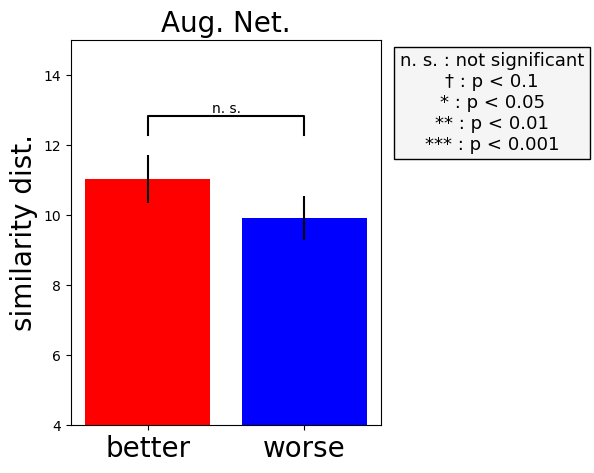

In [4]:
def barplot_annotate_brackets(num1, num2, data, center, 
                              height, yerr=None, dh=.05, 
                              barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.
  
    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
  
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # ↓↓↓↓↓↓↓↓↓↓↓
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        text = ''
        p = .05

        if data >= 0.1:
            text = 'n. s.'
        elif data < 0.1 and data >= 0.05:
            text = '†'
        elif data < 0.05 and data >= 0.01:
            text = '*'
        elif data < 0.01 and data >= 0.001:
            text = '**'
        elif data < 0.001:
            text = '***'
        
  
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
  
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
  
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
  
    y = max(ly, ry) + dh
  
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
  
    plt.plot(barx, bary, c='black')
  
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
  
    plt.text(*mid, text, **kwargs)
    
    #ボックス作成
    pos = plt.gca().get_position()
    s_text = "n. s. : not significant\n† : p < 0.1\n* : p < 0.05\n** : p < 0.01\n*** : p < 0.001"
    dic_box = {
        'facecolor' : 'whitesmoke',
        'edgecolor' : 'black',
        'linewidth' : 1
    }

    #文字とボックスの挿入
    plt.text(pos.x1+1.3, pos.y1+11, s=s_text, 
            color='black', ha='center', fontsize='13', 
            bbox=dic_box)

id = 0
n = 10
# Generate toy data
x1 = worse_dist_ar[id:n]
x0 = better_dist_ar[id:n]

# Welch’s t-test       
t01_value, p01_value = stats.ttest_ind(x0,x1,alternative='less') 
 
""" plot """
heights = [np.mean(x0), np.mean(x1)]
std = [np.std(x0)/np.sqrt(n), np.std(x1)/np.sqrt(n)]
label = ["better", "worse"]
width = 0.8 # the width of the bars
bars = np.arange(len(heights))
colors = ["red", "blue"]

plt.figure(figsize=(4, 5))
plt.bar([0], [np.mean(x0)],yerr=np.std(x0)/np.sqrt(n),color="red")
plt.bar([1], [np.mean(x1)],yerr=np.std(x1)/np.sqrt(n),color="blue")
plt.ylim(4,15)
plt.xticks([0,1],["better","worse"],fontsize=20)
plt.ylabel("similarity dist.",fontsize=20)
plt.title("Aug. Net.",fontsize=20)

barplot_annotate_brackets(0, 1, p01_value, bars,
                          heights, yerr=std)

plt.savefig("../Figure/augnet.eps")

test1 = stats.ttest_ind(x1,x0,alternative='greater')
print(test1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


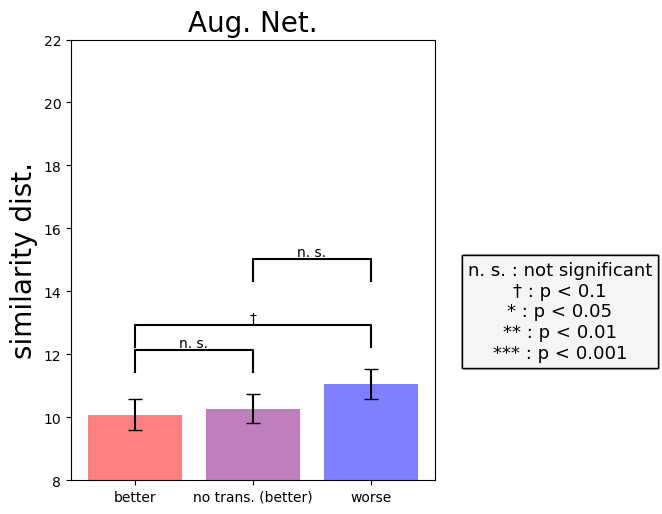

In [63]:
def barplot_annotate_brackets(num1, num2, data, center, 
                              height, yerr=None, dh=.05, 
                              barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.
  
    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
  
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # ↓↓↓↓↓↓↓↓↓↓↓
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        text = ''
        p = .05

        if data >= 0.1:
            text = 'n. s.'
        elif data < 0.1 and data >= 0.05:
            text = '†'
        elif data < 0.05 and data >= 0.01:
            text = '*'
        elif data < 0.01 and data >= 0.001:
            text = '**'
        elif data < 0.001:
            text = '***'
        
  
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
  
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
  
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
  
    y = max(ly, ry) + dh
  
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
  
    plt.plot(barx, bary, c='black')
  
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
  
    plt.text(*mid, text, **kwargs)
    
    #ボックス作成
    pos = plt.gca().get_position()
    s_text = "n. s. : not significant\n† : p < 0.1\n* : p < 0.05\n** : p < 0.01\n*** : p < 0.001"
    dic_box = {
        'facecolor' : 'whitesmoke',
        'edgecolor' : 'black',
        'linewidth' : 1
    }

    #文字とボックスの挿入
    plt.text(pos.x1+2.7, pos.y1+11, s=s_text, 
            color='black', ha='center', fontsize='13', 
            bbox=dic_box)

""" main """
# Generate toy data
x0 = better_dist_ar
x1 = nonsym_better_dist_ar
x2 = worse_dist_ar
 
# Welch’s t-test
t01_value, p01_value = stats.ttest_ind(x0,x1,alternative='less')
t02_value, p02_value = stats.ttest_ind(x0,x2,alternative='less')
t12_value, p12_value = stats.ttest_rel(x1,x2,alternative='less')
 
""" plot """
heights = [np.mean(x0), np.mean(x1), np.mean(x2)]
std = [np.std(x0)/np.sqrt(n), np.std(x1)/np.sqrt(n), np.std(x2)/np.sqrt(n)]
label = ["better","no trans. (better)","worse"]
width = 0.8 # the width of the bars
bars = np.arange(len(heights))
colors = ["red","purple","blue"]
  
plt.figure(figsize=(7, 5))
plt.bar(bars, heights, width, tick_label=label, yerr=std, color=colors,
        align='center', alpha=0.5, ecolor='black', capsize=5)
plt.ylim(8,22)
barplot_annotate_brackets(0, 1, p01_value, bars,
                          heights, yerr=std)
barplot_annotate_brackets(0, 2, p02_value, bars,
                          heights, yerr=std)
barplot_annotate_brackets(1, 2, p12_value, bars,
                          heights, yerr=std,dh=0.2)
plt.tight_layout()
plt.ylabel("similarity dist.",fontsize=20)
plt.title("Aug. Net.",fontsize=20)
plt.savefig("../Figure/augnet_notrans.eps")
plt.show()

In [ ]:
import os
import numpy as np
import cv2
import imgsim
import matplotlib.pyplot as plt
vtr = imgsim.Vectorizer()

# data
DIR_triangle1 =  "./data/triangle1_small.jpg"

# CFG
num_blur = 50
same_triangle_dist_ar = np.zeros((1, num_blur))

# main
for idx in range(1):
    print('id : ', idx)
    img = cv2.imread(DIR_triangle1)
    img1 = img
    # plt.imshow(img1)
    # plt.show()
    img2 = img
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)

    same_triangle_dist_ar[idx][0] = dist

    # print("distance =", dist)
    
    for count in range(1, num_blur):
        img1 = cv2.blur(img1, (4+count, 4+count))
        # plt.imshow(img1)
        # plt.show()

        img2 = cv2.blur(img2, (4+count, 4+count))
        # plt.imshow(img2)
        # plt.show()

        vec1 = vtr.vectorize(img1)
        vec2 = vtr.vectorize(img2)

        dist = imgsim.distance(vec1, vec2)
    
        same_triangle_dist_ar[idx][count] = dist
        
        # print("distance =", dist)

/home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamanaka/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


id :  0


In [ ]:
import os
import numpy as np
import cv2
import imgsim
import matplotlib.pyplot as plt
vtr = imgsim.Vectorizer()

# data
DIR_triangle1 =  "./data/triangle1_small.jpg"
DIR_triangle2 =  "./data/triangle2_small.jpg"

# CFG
num_blur = 50
different_triangle_dist_ar = np.zeros((1, num_blur))

# main
for idx in range(1):
    print('id : ', idx)
    img1 = cv2.imread(DIR_triangle1)
    # plt.imshow(img1)
    # plt.show()
    img2 = cv2.imread(DIR_triangle2)
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)

    different_triangle_dist_ar[idx][0] = dist

    # print("distance =", dist)
    
    for count in range(1, num_blur):
        img1 = cv2.blur(img1, (4+count, 4+count))
        # plt.imshow(img1)
        # plt.show()

        img2 = cv2.blur(img2, (4+count, 4+count))
        # plt.imshow(img2)
        # plt.show()

        vec1 = vtr.vectorize(img1)
        vec2 = vtr.vectorize(img2)

        dist = imgsim.distance(vec1, vec2)
    
        different_triangle_dist_ar[idx][count] = dist
        
        # print("distance =", dist)

id :  0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


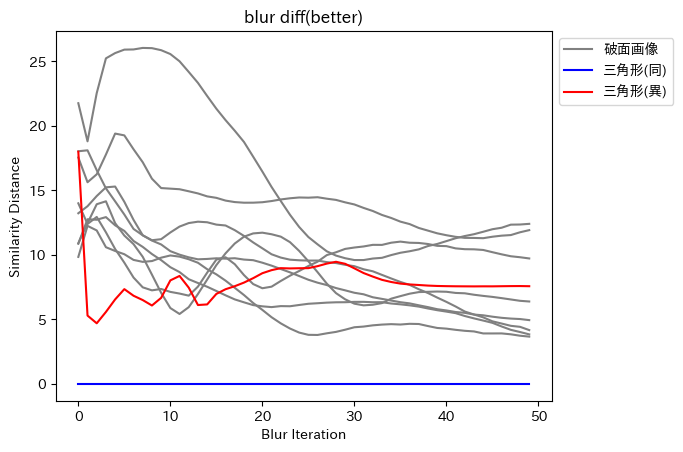

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


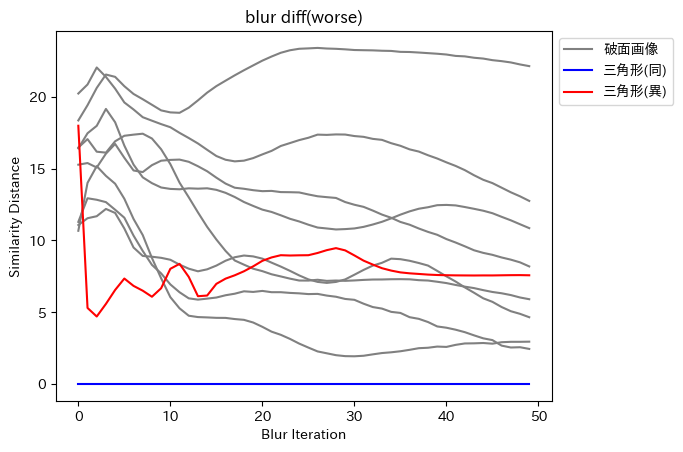

In [ ]:
import japanize_matplotlib
legend_list = ['破面画像', '三角形(同)', '三角形(異)']
handle_list_better = []
handle_list_worse = []

p = plt.plot(better_dist_ar[:8].T, color='gray')
handle_list_better.append(p[0])
p = plt.plot(same_triangle_dist_ar.T, color='blue')
handle_list_better.append(p[0])
p = plt.plot(different_triangle_dist_ar.T, color='red')
handle_list_better.append(p[0])
plt.xlabel('Blur Iteration')
plt.ylabel('Similarity Distance')
plt.legend(handles = handle_list_better, labels = legend_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('blur diff(better)')
plt.savefig('../Figure/symmetry_better.eps')
plt.show()

p = plt.plot(worse_dist_ar[:8].T, color='gray')
handle_list_worse.append(p[0])
p = plt.plot(same_triangle_dist_ar.T, color='blue')
handle_list_worse.append(p[0])
p = plt.plot(different_triangle_dist_ar.T, color='red')
handle_list_worse.append(p[0])
plt.xlabel('Blur Iteration')
plt.ylabel('Similarity Distance')
plt.legend(handles = handle_list_worse, labels = legend_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('blur diff(worse)')
plt.savefig('../Figure/symmetry_worse.eps')
plt.show()




In [ ]:
# ====================================================
# DATA
# ====================================================
df = pd.read_csv('/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/inout_data.csv', header=None, names=['Id', 'KIc'])
df['file_path'] = ['/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(i) + '.jpg' for i in df['Id']]

## vit
vit_oof = pd.read_csv('../KIc/Model/vit/vit_large_patch32_224_Kfold_seed42_oof_df.csv').sort_values(by='Id').reset_index(drop=True)
true_kic_vit = vit_oof['KIc']   

# 区切りの幅を計算
num_bins = 9
bin_width = (np.max(true_kic_vit) - np.min(true_kic_vit)) / num_bins

# middleのidを取得
vit_middle_id = pd.Series([])

for i in range(num_bins):
    bin_lower = np.min(true_kic_vit) + i * bin_width
    bin_upper = bin_lower + bin_width
    bin_mask = (true_kic_vit >= bin_lower) & (true_kic_vit < bin_upper)
    if i == 0:
        low_id_list = vit_oof[bin_mask]['Id']
    elif i == (num_bins - 1):
        high_id_list = vit_oof[bin_mask]['Id']
    else:
        middle_id_list = pd.concat([middle_id_list, vit_oof[bin_mask]['Id']])

# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in low KIc case
# --------------------------------------------------------------------------------
low_dist_ar = np.zeros(n)
low_cos_ar = np.zeros(n)

for idx, low_id in enumerate(low_id_list):
    print('id : ', idx)
    image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(low_id) + '.jpg'
    img0 = cv2.imread(image_path)

    img1 = img0[:int(img0.shape[0]/2), :]
    plt.imshow(img1)
    plt.show()
    img2 = img0[int(img0.shape[0]/2):, :][::-1] if img0.shape[0] % 2 == 0 else img0[int(img0.shape[0]/2):img0.shape[0]-1, :][::-1]
    plt.imshow(img2)
    plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)
    low_dist_ar[idx] = dist

    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = img1.flatten()
    img2 = img2.flatten()
    low_cos_ar[idx] = cos_sim(img1,img2)
    print("distance =", dist)
    print("distance =", cos_sim(img1,img2))


# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in high KIc case
# --------------------------------------------------------------------------------
high_dist_ar = np.zeros(n)
high_cos_ar = np.zeros(n)

for idx, high_id in enumerate(high_id_list):
    print('id : ', idx)
    image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(high_id) + '.jpg'
    img0 = cv2.imread(image_path)
        
    img1 = img0[:int(img0.shape[0]/2), :]
    plt.imshow(img1)
    plt.show()
    img2 = img0[int(img0.shape[0]/2):, :][::-1] if img0.shape[0] % 2 == 0 else img0[int(img0.shape[0]/2):img0.shape[0]-1, :][::-1]
    plt.imshow(img2)
    plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)
    high_dist_ar[idx] = dist
    
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = img1.flatten()
    img2 = img2.flatten()
    high_cos_ar[idx] = cos_sim(img1,img2)
    print("distance =", dist)
    print("distance =", cos_sim(img1,img2))


# --------------------------------------------------------------------------------
# define the function to calculate the symmetric similarity in middle KIc case
# --------------------------------------------------------------------------------
middle_dist_ar = np.zeros(n)
middle_cos_ar = np.zeros(n)

for idx, middle_id in enumerate(middle_id_list):
    print('id : ', idx)
    image_path = '/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(middle_id) + '.jpg'
    img0 = cv2.imread(image_path)
    
    img1 = img0[:int(img0.shape[0]/2), :]
    plt.imshow(img1)
    plt.show()
    img2 = img0[int(img0.shape[0]/2):, :][::-1] if img0.shape[0] % 2 == 0 else img0[int(img0.shape[0]/2):img0.shape[0]-1, :][::-1]
    plt.imshow(img2)
    plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)
    middle_dist_ar[idx] = dist
    
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = img1.flatten()
    img2 = img2.flatten()
    middle_cos_ar[idx] = cos_sim(img1,img2)
    print("distance =", dist)
    print("distance =", cos_sim(img1,img2))


In [18]:
# ====================================================
# DATA
# ====================================================
df = pd.read_csv('/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/inout_data.csv', header=None, names=['Id', 'KIc'])
df['file_path'] = ['/home/yamanaka/Estimate_KIc_with_ViT/Mototake_Analysis/VGG+GP/imagedata/' + str(i) + '.jpg' for i in df['Id']]

## vit
vit_oof = pd.read_csv('../KIc/Model/vit/vit_large_patch32_224_Kfold_seed42_oof_df.csv').sort_values(by='Id').reset_index(drop=True)
true_kic_vit = vit_oof['KIc']   

# 区切りの幅を計算
num_bins = 9
bin_width = (np.max(true_kic_vit) - np.min(true_kic_vit)) / num_bins

# middleのidを取得
vit_middle_id = pd.Series([])

for i in range(num_bins):
    bin_lower = np.min(true_kic_vit) + i * bin_width
    bin_upper = bin_lower + bin_width
    bin_mask = (true_kic_vit >= bin_lower) & (true_kic_vit < bin_upper)
    if i == 0:
        vit_low_id = vit_oof[bin_mask]['Id']
    elif i == (num_bins - 1)
        vit_high_id = vit_oof[bin_mask]['Id']
    else:
        vit_middle_id = pd.concat([vit_middle_id, vit_oof[bin_mask]['Id']])

# ====================================================
# SYMMETRIC
# ====================================================
num_blur = 50
high_dist_ar = np.zeros((len(vit_high_id), num_blur))
low_dist_ar = np.zeros((len(vit_low_id), num_blur))
middle_dist_ar = np.zeros((len(vit_middle_id), num_blur))

for high_idx, high_id in enumerate(vit_high_id):
    print('id : ', high_idx)
    image_path = '../KIc/Image_Original/1' + str(high_id).zfill(5) + '.jpg'
    img0 = cv2.imread(image_path)
    img1 = img0[55:240,120:540]
    # plt.imshow(img1)
    # plt.show()
    img2 = img0[240:430,120:540][::-1]
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)

    high_dist_ar[high_idx][0] = dist

    # print("distance =", dist)
    
    for count in range(1, num_blur):
        img1 = cv2.blur(img1, (5, 5))
        # plt.imshow(img1)
        # plt.show()

        img2 = cv2.blur(img2, (5, 5))
        # plt.imshow(img2)
        # plt.show()

        vec1 = vtr.vectorize(img1)
        vec2 = vtr.vectorize(img2)

        dist = imgsim.distance(vec1, vec2)
    
        high_dist_ar[high_idx][count] = dist
        
        # print("distance =", dist)

for low_idx, low_id in enumerate(vit_low_id):
    print('id : ', low_idx)
    image_path = '../KIc/Image_Original/1' + str(low_id).zfill(5) + '.jpg'
    img0 = cv2.imread(image_path)
    img1 = img0[55:240,120:540]
    # plt.imshow(img1)
    # plt.show()
    img2 = img0[240:430,120:540][::-1]
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)

    low_dist_ar[low_idx][0] = dist

    # print("distance =", dist)
    
    for count in range(1, num_blur):
        img1 = cv2.blur(img1, (5, 5))
        # plt.imshow(img1)
        # plt.show()

        img2 = cv2.blur(img2, (5, 5))
        # plt.imshow(img2)
        # plt.show()

        vec1 = vtr.vectorize(img1)
        vec2 = vtr.vectorize(img2)

        dist = imgsim.distance(vec1, vec2)
    
        low_dist_ar[low_idx][count] = dist
        
        # print("distance =", dist)

for middle_idx, middle_id in enumerate(vit_middle_id):
    print('id : ', middle_idx)
    image_path = '../KIc/Image_Original/1' + str(middle_id).zfill(5) + '.jpg'
    img0 = cv2.imread(image_path)
    img1 = img0[55:240,120:540]
    # plt.imshow(img1)
    # plt.show()
    img2 = img0[240:430,120:540][::-1]
    # plt.imshow(img2)
    # plt.show()

    vec1 = vtr.vectorize(img1)
    vec2 = vtr.vectorize(img2)

    dist = imgsim.distance(vec1, vec2)

    middle_dist_ar[middle_idx][0] = dist

    # print("distance =", dist)
    
    for count in range(1, num_blur):
        img1 = cv2.blur(img1, (5, 5))
        # plt.imshow(img1)
        # plt.show()

        img2 = cv2.blur(img2, (5, 5))
        # plt.imshow(img2)
        # plt.show()

        vec1 = vtr.vectorize(img1)
        vec2 = vtr.vectorize(img2)

        dist = imgsim.distance(vec1, vec2)
    
        middle_dist_ar[middle_idx][count] = dist
        
        # print("distance =", dist)

/tmp/ipykernel_1452378/1645100804.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  vit_middle_id = pd.concat([vit_middle_id, vit_oof[bin_mask]['Id'][:10]])


id :  0
id :  1
id :  2
id :  3
id :  4
id :  5
id :  6
id :  7
id :  8
id :  9
id :  0
id :  1
id :  2
id :  3
id :  4
id :  5
id :  6
id :  7
id :  8
id :  9
id :  0
id :  1
id :  2
id :  3
id :  4
id :  5
id :  6
id :  7
id :  8
id :  9
id :  10
id :  11
id :  12
id :  13
id :  14
id :  15
id :  16
id :  17
id :  18
id :  19
id :  20
id :  21
id :  22
id :  23
id :  24
id :  25
id :  26
id :  27
id :  28
id :  29
id :  30
id :  31
id :  32
id :  33
id :  34
id :  35
id :  36
id :  37
id :  38
id :  39
id :  40
id :  41
id :  42
id :  43
id :  44
id :  45
id :  46
id :  47
id :  48
id :  49
id :  50
id :  51
id :  52
id :  53
id :  54
id :  55
id :  56
id :  57
id :  58
id :  59
id :  60
id :  61
id :  62
id :  63
id :  64
id :  65
id :  66
id :  67
id :  68
id :  69
id :  70
id :  71
id :  72
id :  73
id :  74
id :  75
id :  76
id :  77
id :  78
id :  79


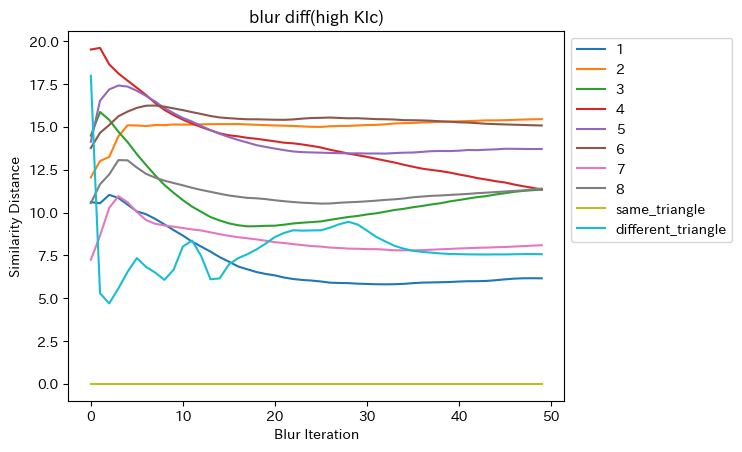

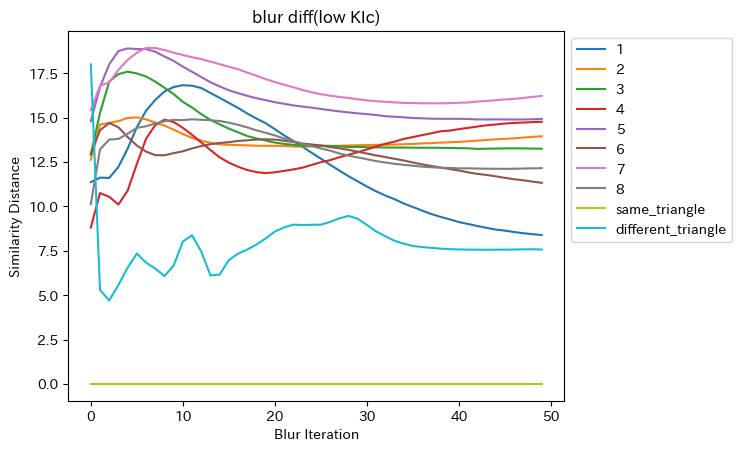

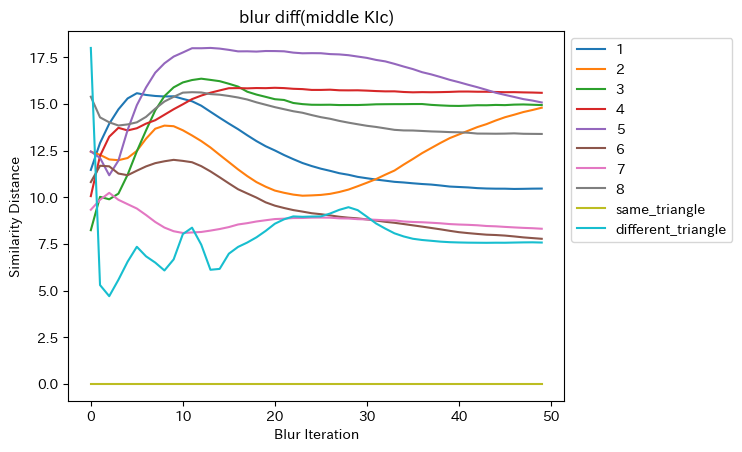

In [19]:
combined_high_dist_ar = np.concatenate((high_dist_ar[:8], same_triangle_dist_ar, different_triangle_dist_ar), axis=0)
plt.plot(combined_high_dist_ar.T)
plt.xlabel('Blur Iteration')
plt.ylabel('Similarity Distance')
plt.legend([f'{i}' for i in range(1, len(high_dist_ar[:8])+1)] + ['same_triangle', 'different_triangle'], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('blur diff(high KIc)')
plt.savefig('./data/symmetry_high.png')
plt.show()

combined_low_dist_ar = np.concatenate((low_dist_ar[:8], same_triangle_dist_ar, different_triangle_dist_ar), axis=0)
plt.plot(combined_low_dist_ar.T)
plt.xlabel('Blur Iteration')
plt.ylabel('Similarity Distance')
plt.legend([f'{i}' for i in range(1, len(low_dist_ar[:8])+1)] + ['same_triangle', 'different_triangle'], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('blur diff(low KIc)')
plt.savefig('./data/symmetry_low.png')
plt.show()

combined_middle_dist_ar = np.concatenate((middle_dist_ar[:8], same_triangle_dist_ar, different_triangle_dist_ar), axis=0)
plt.plot(combined_middle_dist_ar.T)
plt.xlabel('Blur Iteration')
plt.ylabel('Similarity Distance')
plt.legend([f'{i}' for i in range(1, len(middle_dist_ar[:8])+1)] + ['same_triangle', 'different_triangle'], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('blur diff(middle KIc)')
plt.savefig('./data/symmetry_middle.png')
plt.show()